### Backends

You can change the backend to perform computation with a different framework. By default, the backend is JAX, but you can also perform the computation using PyTorch or set up your own backend, if you need. For instance, after setting the backend to PyTorch, all the computation is done by PyTorch. It doesn't matter, which backend you are using: the interface remains the same.

Let us give some examples:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

from src import backend as back
from src import set_backend

First of all let's try default (JAX) backend:

In [2]:
A = back.tensor(np.random.rand(3, 3))
print(type(A)) # jax DeviceArray
print(back.svd(A, full_matrices=False)[1])
# we can cast tensor to numpy array from any backend at any time
Q = back.qr(A)[0]
Q = back.to_numpy(Q)
print(np.allclose(np.eye(3), Q.T @ Q))

<class 'jaxlib.xla_extension.DeviceArray'>
[1.73633448 0.43699676 0.05646881]
True


And now let's switch to PyTorch

In [3]:
set_backend("pytorch")
# and now we will do all the same operations
A = back.randn((3, 3)) # we don't actually need numpy here
print(type(A)) # pytorch tensor
print(back.svd(A, full_matrices=False)[1])
# we can cast tensor to numpy array from any backend at any time
Q = back.qr(A)[0]
Q = back.to_numpy(Q)
print(np.allclose(np.eye(3), Q.T @ Q))

<class 'torch.Tensor'>
tensor([2.1411, 1.3904, 0.3182], dtype=torch.float64)
True


#### Autodiff

Now we are calculating Riemann gradient using JAX and PyTorch backends.
Let us prepare some code for demostration.

In [4]:
from src.tucker import Tucker
from src.riemopt import compute_gradient_projection

def f(T: Tucker):
    A = T.full()
    return (A ** 2 - A).sum()

random_seed = 42

def calculate_grads(n):
    set_backend("jax")
    A = back.randn((n, n, n), random_seed)
    T = Tucker.full2tuck(A)
    grad_jax = compute_gradient_projection(f, T)
    grad_jax = back.to_numpy(grad_jax.full())
    set_backend("pytorch")
    A = back.randn((n, n, n), random_seed)
    T = Tucker.full2tuck(A)
    grad_torch = compute_gradient_projection(f, T)
    grad_torch = back.to_numpy(grad_torch.full())
    return grad_jax, grad_torch

And now let's explore difference between jax grad and torch grad:

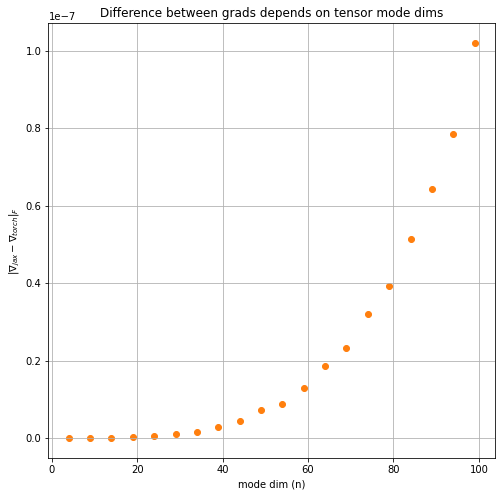

In [5]:
Ns = np.arange(4, 101, 5)
plt.xlabel("mode dim (n)")
plt.ylabel(r"$\|\nabla_{jax} - \nabla_{torch}\|_F$")
plt.title("Difference between grads depends on tensor mode dims")
for n in Ns:
    grad_jax, grad_torch = calculate_grads(n)
    plt.scatter(n, np.linalg.norm(grad_jax - grad_torch), c="tab:orange")
plt.grid()
plt.show()

We may note that difference grows exponentially with the tensor modes dimension.
Let's figure out, why does it happen:

In [6]:
n = 2
set_backend("jax")
A = back.randn((n, n, n), random_seed)
T = Tucker.full2tuck(A)
grad_jax = compute_gradient_projection(f, T)
grad_jax_core = back.to_numpy(grad_jax.core)
grad_jax_factors = [back.to_numpy(factor) for factor in grad_jax.factors]
set_backend("pytorch")
A = back.randn((n, n, n), random_seed)
T = Tucker.full2tuck(A)
grad_torch = compute_gradient_projection(f, T)
grad_torch_core = back.to_numpy(grad_torch.core)
grad_torch_factors = [back.to_numpy(factor) for factor in grad_torch.factors]

print("Difference in gradient cores: %.5f" % np.linalg.norm(grad_jax_core - grad_torch_core))
print("Difference in gradient factors: %.5f, %.5f, %.5f" % (
    np.linalg.norm(grad_jax_factors[0] - grad_torch_factors[0]),
    np.linalg.norm(grad_jax_factors[1] - grad_torch_factors[1]),
    np.linalg.norm(grad_jax_factors[2] - grad_torch_factors[2])))

Difference in gradient cores: 10.86907
Difference in gradient factors: 2.00000, 2.00000, 2.00000
